<center><img src="https://i.imgur.com/bIw8deA.jpg" width="1000px"></center>

# Introduction

Welcome to the "Cornell Birdcall Identification" challenge on Kaggle! In this challenge, contestants need to identify the species of birds involved in audio clips of them calling. In this kernel, I will build a comprehensive pipeline based on <code>melspectrogram</code> audio transformation and the <code>ResNet</code> pretrained image model to identify bird species from audio samples. I'm very excited about this challenge because I love birds and I'm dealing with audio data for the first time, so let's get straight to it!

# Acknowledgements

1. [LibROSA](https://librosa.org/librosa/) ~ by the librosa team
2. [Audio Data Analysis Using librosa 📈](https://www.kaggle.com/hamditarek/audio-data-analysis-using-librosa) ~ by Tarek Hamdi
3. [Understanding the Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) ~ by Leland Roberts
4. [Bidirectional LSTM for audio labeling with Keras](https://www.kaggle.com/carlolepelaars/bidirectional-lstm-for-audio-labeling-with-keras) ~ by Carlo Lepelaars

# Contents

1. [<font size=4>Preparing the ground</font>](#1)
    * [Install additional packages](#1.1)
    * [Import necessary libraries](#1.2)
    * [Define key hyperparameters and paths](#1.3)
    * [Load metadata from .csv files](#1.4)


2. [<font size=4>EDA</font>](#2)
    * [ebird_code](#2.1)
    * [duration](#2.2)
    * [pitch](#2.3)
    * [channels](#2.4)

    
3. [<font size=4>Modeling</font>](#3)
    * [Data processing](#3.1)
    * [Define PyTorch data loading pipeline](#3.2)
    * [Define PyTorch modelling pipeline](#3.3)
    * [Define binary cross entropy and accuracy](#3.4)
    * [Train the model on GPU](#3.5)
    * [Define PyTorch inference pipeline](#3.6)

# Preparing the ground <a id="1"></a>

In this section, we will prepare the ground to train and test the model by installing packages, setting hyperparameters, and loading the data.

## Install additional packages <a id="1.1"></a>

* We will now install two other packages: <code>colored</code> and <code>pydub</code>
* <code>colored</code> helps add foreground colors to text output in Python to make training logs more readable.
* <code>pydub</code> will help us load audio data from <code>.mp3</code> files much faster than the <code>librosa</code> command: <code>librosa.load</code>

In [4]:
!pip install -q pydub
!pip install -q colored

## Import necessary libraries <a id="1.2"></a>

* Now, we import all the libraries we need.
* <code>colored</code>, <code>matplotlib</code> and <code>tqdm</code> for data analysis and visualization.
* <code>numpy</code>, <code>pandas</code>, and <code>sklearn</code> for data processing and manipulation.
* <code>librosa</code>, <code>pydub</code>, <code>keras</code> and <code>torch</code> for model training and inference.

In [83]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import IPython
import IPython.display as ipd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colored import fg, bg, attr
from sklearn.utils import shuffle

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pydub
import librosa
import librosa.display
from pydub import AudioSegment as AS
from librosa.feature import melspectrogram
from librosa.core import power_to_db as ptdb

import torch
import torch.nn as nn
from torch.optim import Adam
from albumentations import Normalize
from torchvision.models import resnet34
from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor, DoubleTensor

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences as pad

In [84]:
torch.backends.cudnn.benchmark = True

## Define key hyperparameters and paths <a id="1.3"></a>

* Here we define the key hyperparameters: sequence length, train/val split, batch size, epochs, LR.
* We also specify the correct paths for loading data, training, inference, and finally submission to this competition.

### Define hyperparameters

The hyperparameters used are documented below ~

1. Data processing related

    * <code>N_MELS</code> is the number of <code>melspectrogram</code> features per time step.
    * <code>MEL_LEN</code> is the total number of time steps in each <code>melspectrogram</code>.
    * <code>AMPLITUDE</code> represents the default signal amplitude applied to unreadable files.
    * <code>SR</code> is the sampling rate at which the audio is loaded (readings per second). It defaults to <code>44100 Hz</code>.
    * <code>TSR</code> is the sampling rate at which the test audio clips are loaded. It defaults to <code>32000 Hz</code>.
    * <code>MAXLEN</code> is the maximum number of readings. Longer clips will be trimmed and shorter ones will be padded.
    * <code>SPLIT</code> represents the fraction of data to be used for training. The rest of the data is used for validation.
    * <code>CHUNKS</code> represents the number of chunks that will be extracted from each signal. It defaults to <code>1</code> per signal.
    * <code>CHUNK_SIZE</code> represents the sequence length of each audio chunk to be fed into the <code>melspectrogram</code> function.
    * <code>POP_FRAC</code> is the maximum proportion of signal information to be ignored per chunk (defaults to <code>0.25</code>).


2. Modelling related
    
    * <code>F</code> represents the number of total number of features output by the <code>ResNet</code> model (defaults to <code>512</code>).
    * <code>DROP</code> represents the dropout rate between the feature layer and final <code>264D</code> output layer (<code>0.2</code>).
    * <code>LEARNING_RATE</code> represents the learning rate of the model. It defaults to a low value of <code>1e-3</code>.
    * <code>BATCH_SIZE</code> is the size of each minibatch to be fed into the model while training (defaults to <code>128</code>).
    * <code>VAL_BATCH_SIZE</code> is the size of each minibatch to be fed into the model while validating (defaults to <code>128</code>).
    * <code>EPOCHS</code> represents the number of times the training dataset is fed into the model (defaults to <code>2</code>).

    
3. Submission related

    * <code>MAX_OUTPUTS</code> is the maximum number of bird species to be output per audio clip (defaults to <code>3</code>).
    * <code>THRESHOLD</code> is the minimum probability required for a bird species to be selected (defaults to <code>6e-3</code>).
    * <code>MIN_THRESHOLD</code> is the minimum probability required in a list of probabilities to assign any bird species.

      (*Note*: If the maximum probability falls below <code>MIN_THESHOLD</code>, <code>nocall</code> will be predicted.)

In [85]:
F = 512
DROP = 0.2
EPOCHS = 20
LR = 1e-3, 1e-2
VAL_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16

MAX_OUTPUTS = 3
THRESHOLD = 6e-3
MIN_THRESHOLD = 5e-3

SR = 44100
CHUNKS = 1
TSR = 32000
SPLIT = 0.8
N_MELS = 256
MEL_LEN = 1954
POP_FRAC = 0.25
MAXLEN = 1000000
AMPLITUDE = 1000
CHUNK_SIZE = 1000000

### Check data available

We have three datasets at our disposal

1. <code>birdsong-recognition</code>
2. <code>prepare-check-dataset</code>
3. <code>birdcall-identification-spectrogram-loader</code>

In [94]:
os.listdir('/Users/Nithin/Desktop/Endterm/final')

['.ipynb_checkpoints',
 'birdcall-check',
 'birdcall-identification-spectrogram-loader',
 'birdcall-identification-spectrogram-resnet.ipynb',
 'birdsong-recognition']

### Unzip .zip files wth spectrogram images

In [47]:
!unzip birdcall-identification-spectrogram-loader/train_1.zip
!unzip birdcall-identification-spectrogram-loader/train_2.zip
!unzip birdcall-identification-spectrogram-loader/train_3.zip
!unzip birdcall-identification-spectrogram-loader/train_4.zip
!unzip birdcall-identification-spectrogram-loader/train_5.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Define paths

The paths used are documented below ~

1. Metadata related

    * <code>../input/birdsong-recognition/test.csv</code> contains the test metadata used for submission.
    * <code>../input/birdsong-recognition/train.csv</code> contains the train metadata used for submission.
    * <code>../input/prepare-check-dataset/test.csv</code> contains the test metadata used for committing.


2. Audio data related

    * <code>../input/birdsong-recognition/test_audio</code> contains the test audio used for submission.
    * <code>../input/birdsong-recognition/train_audio</code> contains the train audio used for submission.
    * <code>../input/prepare-check-dataset/test_audio</code> contains the test audio used for committing.


3. Spectrogram related

    * <code>IMG_PATHS</code> contains a list of folders with the already generated training spectrograms.

In [50]:
TEST_DATA_PATH = 'birdsong-recognition/test.csv'
TRAIN_DATA_PATH = 'birdsong-recognition/train.csv'
TEST_AUDIO_PATH = 'birdsong-recognition/test_audio/'
TRAIN_AUDIO_PATH = 'birdsong-recognition/train_audio/'
CHECKING_PATH = 'birdcall-check/'
IMG_PATHS = ['train_1', 'train_2', 'train_3', 'train_4', 'train_5']

In [56]:
PATH_DICT = {}
for folder_path in tqdm(IMG_PATHS):
    folder_path = "birdcall-identification-spectrogram-loader/"+folder_path
    for img_path in os.listdir(folder_path):
        PATH_DICT[img_path] = folder_path + '/'

In [57]:
sub = os.path.exists(TEST_AUDIO_PATH)
TEST_DATA_PATH = TEST_DATA_PATH if sub else CHECKING_PATH + 'test.csv'
TEST_AUDIO_PATH = TEST_AUDIO_PATH if sub else CHECKING_PATH + 'test_audio/'

## Load metadata from .csv files <a id="1.4"></a>

* Now we load the training and testing metadata.

* We can see that the testing dataframe has only <code>3</code> rows in it.

* This is only a dummy test dataframe. The actual testing data will be used during submission.

In [58]:
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)

In [59]:
test_df.head()

,site,row_id,seconds,audio_id
0,site_1,site_1_41e6fe6504a34bf6846938ba78d13df1_5,5.0,41e6fe6504a34bf6846938ba78d13df1
1,site_1,site_1_41e6fe6504a34bf6846938ba78d13df1_10,10.0,41e6fe6504a34bf6846938ba78d13df1
2,site_1,site_1_41e6fe6504a34bf6846938ba78d13df1_15,15.0,41e6fe6504a34bf6846938ba78d13df1
3,site_1,site_1_41e6fe6504a34bf6846938ba78d13df1_20,20.0,41e6fe6504a34bf6846938ba78d13df1
4,site_1,site_1_41e6fe6504a34bf6846938ba78d13df1_25,25.0,41e6fe6504a34bf6846938ba78d13df1


In [60]:
train_df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


### Prepare the label dictionary

* Next we prepare a dictionary linking each bird species to a unique integer.
* This dictionary will help us when we need to one-hot encode our targets later.

In [61]:
keys = set(train_df.ebird_code)
values = np.arange(0, len(keys))
code_dict = dict(zip(sorted(keys), values))

# EDA <a id="2"></a>

Now let us carry out some basic visualization to get a better idea of the data.

## ebird_code <a id="2.1"></a>

The <code>ebird_code</code> is a code assigned to each bird species.

In [62]:
counts = [list(train_df.ebird_code).count(code) for code in set(train_df.ebird_code)]
idx = np.argsort(counts)
df = pd.DataFrame(np.transpose([np.array(list(set(train_df.ebird_code)))[idx], np.array(counts)[idx]]))
df.columns = ["Bird species", "Count"]
fig = px.bar(df, x="Count", y="Bird species", title="Bird species vs. Count", template="simple_white")
fig.data[0].orientation = 'h'
fig.update_layout(height=1800, paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()

From the above plot, we can see that the maximum number of audio samples per species in the training data is <code>100</code>. There are many species with less than <code>100</code> samples in the training data, such as <code>redhea</code>, <code>buffle</code>, and <code>coshum</code> with <code>9</code>, <code>15</code>, and <code>19</code> samples respectively.

## duration <a id="2.2"></a>

The <code>duration</code> is the length of the audio clip in seconds.

In [63]:
nums_1 = train_df.duration
nums_1 = nums_1.fillna(nums_1.mean())

fig = ff.create_distplot(hist_data=[nums_1],
                         group_labels=["0"],
                         colors=["seagreen"], show_hist=False)

fig.update_layout(title_text="Duration distribution", xaxis_title="Duration",
                  template="plotly_white", paper_bgcolor="#edebeb")
fig.show()

From the distribution plot above, we can see that most clips last between <code>5</code> to <code>35</code> seconds. Overall, the distribution has a very clear positive/rightward skew as the probability density narrows down towards the right.

## pitch <a id="2.3"></a>

The <code>pitch</code> describes the change in frequency of the bird's call over time (increasing, descreasing, etc).

In [64]:
counts = [list(train_df.pitch).count(code) for code in set(train_df.pitch)]
df = pd.DataFrame(np.transpose([list(set(train_df.pitch)), counts]))
df.columns = ["Pitch", "Count"]
fig = px.pie(df, names="Pitch", values="Count", title="Pitch", color_discrete_sequence=list(reversed(px.colors.cyclical.Edge)))
fig.update_layout(paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()

From the pie chart above, we can see that most audio clips do not have a specified <code>pitch</code>. The <code>level</code> and <code>both</code> pitches are second in frequency to <code>not specified</code>, followed by <code>decreasing</code> and <code>increasing</code>.

## channels <a id="2.4"></a>

The <code>channels</code> indicates the number of channels in the audio clip (1: <code>mono</code> or 2: <code>stereo</code>).

In [65]:
counts = [list(train_df.channels).count(code) for code in set(train_df.channels)]
df = pd.DataFrame(np.transpose([list(set(train_df.channels)), counts]))
df.columns = ["Channels", "Count"]
colors = px.colors.qualitative.Plotly
fig = px.pie(df, names="Channels", values="Count", title="Channels", color_discrete_sequence=["darkblue", "SteelBlue"])
fig.update_layout(paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()

It can be seen that a somewhat even number of audio clips are <code>mono</code> (<code>53.7%</code>) <code>stereo</code> (<code>46.3%</code>). In this project, we deal with this by concatenating the multiple channels into a single signal.

<center><img src="https://i.imgur.com/ZwkZIbN.jpg" width="600px"></center>

# Modelling <a id="3"></a>

Now it's time to start with the process of building our audio classification pipeline.

## Data processing <a id="3.1"></a>

The first step to define important function to process the data and generate features.

### Define utility function to read audio

* Now we define a function using <code>pydub</code> to read audio files into <code>numpy</code> arrays.
* This implementation is significantly faster than <code>librosa.load</code> and <code>torchaudio.load</code>.

In [66]:
def normalize(x):
    return np.float32(x)/2**15

def read(file, norm=False):
    try: a = AS.from_mp3(file)
    except: return np.zeros(MAXLEN)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2: y = y.reshape((-1, 2))
    if norm: return a.frame_rate, normalize(y)
    if not norm: return a.frame_rate, np.float32(y)

def write(file, sr, x, normalized=False):
    birds_audio_bitrate, file_format = '320k', 'mp3'
    ch = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    y = np.int16(x * 2 ** 15) if normalized else np.int16(x)
    song = AS(y.tobytes(), frame_rate=sr, sample_width=2, channels=ch)
    song.export(file, format=file_format, bitrate=birds_audio_bitrate)

### Define helper function to convert NumPy arrays to PyTorch tensors

* This is a function that takes a list of <code>numpy</code> arrays as input and outputs a list of <code>torch</code> tensors.

In [67]:
def to_tensor(data):
    return [FloatTensor(point) for point in data]

### Define functions to process audio signals

These are a set of functions which process the audio before the <code>melspectrogram</code> transformation.

The functions used are documented below ~

* <code>get_idx</code> selects the start and end index of a given audio chunk.
* <code>get_chunk</code> takes indices from <code>get_idx</code> and outputs a chunk of data between those indices.
* <code>get_len</code> is a helper function which is used to decide possible chunk indices based on <code>POP_FRAC</code>.
  
  --> <code>If</code> the signal is longer than <code>MAXLEN</code>, it sets the maximum index to <code>MAXLEN</code>.<br>
  --> <code>Else</code> it uses <code>POP_FRAC</code> to ensure chunks are centered around audio signal and not padding.


* <code>get_signal</code> flattens the signal, pads it to <code>MAXLEN</code>, and stacks multiple chunks into one array.

In [68]:
def get_idx(length):
    length = get_len(length)
    max_idx = MAXLEN - CHUNK_SIZE
    idx = np.random.randint(length + 1)
    chunk_range = idx, idx + CHUNK_SIZE
    chunk_idx = max([0, chunk_range[0]])
    chunk_idx = min([chunk_range[1], max_idx])
    return (chunk_idx, chunk_idx + CHUNK_SIZE)

def get_len(length):
    if length > MAXLEN: return MAXLEN
    if length <= MAXLEN: return int(length*POP_FRAC)

In [69]:
def get_chunk(data, length):
    index = get_idx(length)
    return data[index[0]:index[1]]

def get_signal(data):
    length = max(data.shape)
    data = data.T.flatten().reshape(1, -1)
    data = np.float32(pad(data, maxlen=MAXLEN).reshape(-1))
    return [get_chunk(data, length) for _ in range(CHUNKS)]

<center><img src="https://i.imgur.com/FVBe3vX.png" width="750px"></center>

### Understanding melspectrogram

To understand the <code>melspectrogram</code>, one needs to first understand the <code>fourier transform</code>. In simple terms, it is a transformation that allows us to analyze the frequency content of a signal effectively. But unfortunately, the <code>fourier transform</code> requires the signal to be periodic to get optimal results.

This problem can be solved by applying the <code>fourier transform</code> on multiple windowed segments of the signals to capture the frequency content as it changes over time. This is called the <code>short-time fourier transform</code> or <code>STFT</code> for short. When the <code>fourier transform</code> is applied on overlapping windowed segments of the signal, what we get what is called a <code>spectrogram</code>.

A <code>spectrogram</code> can be thought of as several <code>fourier transforms</code> stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. The y-axis is converted to a log scale, and the color dimension is converted to decibels. This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.

Moreover, studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between <code>500</code> and <code>1000 Hz</code>, but we will hardly be able to tell a difference between <code>10,000</code> and <code>10,500 Hz</code>, even though the distance between the two pairs are the same.
In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.

A <code>spectrogram</code> converted to the <code>mel</code> scale is called a <code>melspectrogram</code> and is a great way to convert audio signal data to a visual feature map to train an image model (like <code>ResNet-34</code>) on. Refer to [this article](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) for an excellent explanation of <code>melspectrogram</code>. Now, since we understand how the <code>melspectrogram</code> works, let us move on to the modelling part.

### Define functions to calculate melspectrogram features

Below we define some functions to calculate the <code>melspectrogram</code> features from audio signals.

In [70]:
def to_imagenet(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = (V - norm_min) / (norm_max - norm_min)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return np.stack([V]*3, axis=-1)

In [71]:
def get_melsp(data):
    melsp = melspectrogram(data, n_mels=N_MELS)
    return to_imagenet(librosa.power_to_db(melsp))

def get_melsp_img(data):
    data = get_signal(data)
    return np.stack([get_melsp(point) for point in data])

### Visualize melspectrogram

Next we visualize the <code>melspectrogram</code> feature maps for sample signals to get an better understanding. We can see that the <code>melspectrogram</code> contains visual information about the trends (<code>frequency</code> and <code>amplitude</code>) in the audio signal over time.

In [72]:
def viz(species):
    data = train_df.query('ebird_code == "{}"'.format(species))
    
    data = data.reset_index(drop=True)
    ebird_code, filename = data.ebird_code.loc[0], data.filename.loc[0]
    print(TRAIN_AUDIO_PATH + species + '/' + filename)
    sample_rate,dummy= read(TRAIN_AUDIO_PATH + species + '/' + filename)
    ipd.Audio(TRAIN_AUDIO_PATH + species + '/' + filename,sample_rate)

    f, pth = (30, 5), TRAIN_AUDIO_PATH
    fig, ax = plt.subplots(nrows=CHUNKS, ncols=2, figsize=f)

    ax[0].set_title(species + " signal", fontsize=16)
    ax[1].set_title(species + " melspectrogram", fontsize=16)

    sr, data = read(pth + ebird_code + '/' + filename)
    signals, melsp_features = get_signal(data), get_melsp_img(data)

    values = zip(signals, melsp_features)
    for i, (signal, melsp_feature) in enumerate(values):
        ax[0].plot(signal, 'crimson'); ax[1].imshow(cv2.resize(melsp_feature, (4096, 1024)))
    
    display(ipd.Audio(pth + ebird_code + '/' + filename))
    plt.show()

### Aldfly

In [73]:
viz('aldfly')

birdsong-recognition/train_audio/aldfly/XC134874.mp3


ValueError: too many values to unpack (expected 2)

### Canware

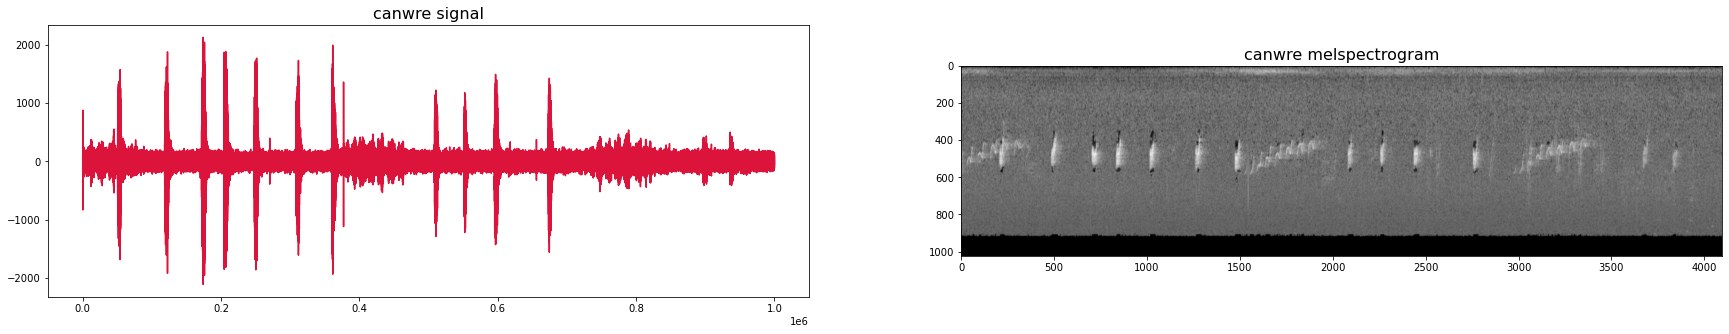

In [26]:
viz('canwre')

### Lesgol

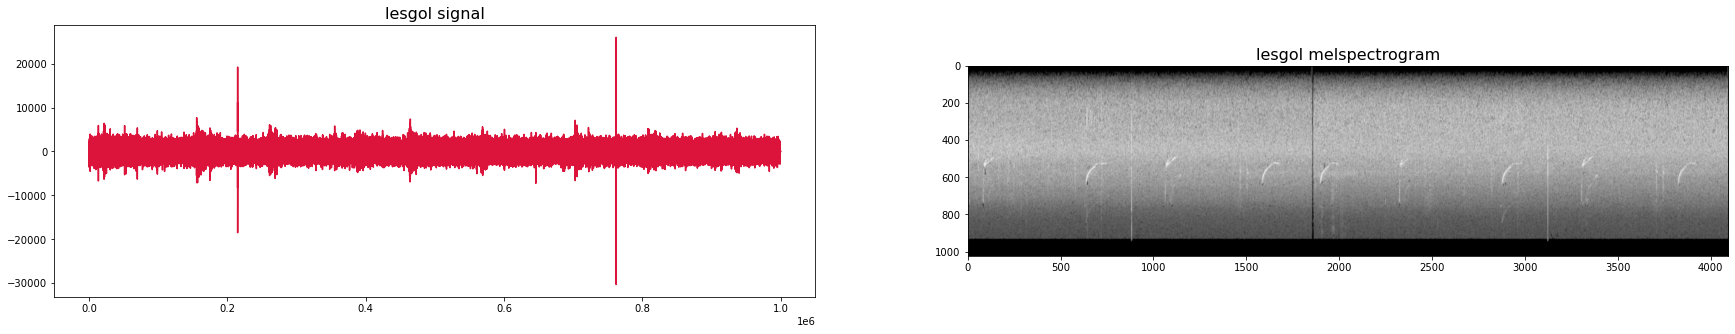

In [27]:
viz('lesgol')

## Define PyTorch data loading pipeline <a id="3.2"></a>

### Define PyTorch dataset

Now we need to define a PyTorch dataset to load data for the <code>ResNet-34</code> model.

* A PyTorch dataset has three fundamental functions: <code>init</code>, <code>len</code>, and <code>getitem</code>.
* The <code>init</code> function initializes all the components required for data loading (paths, metadata, etc).
* The <code>len</code> function simply returns the length of the dataset. This indicates the number of retrievable samples.
* The <code>getitem</code> function returns a data point at a given index <code>idx</code>. The actual logic is written in this function.
* The <code>getitem</code> function does 2 things: gets the <code>one-hot</code> targets and <code>melspectrogram</code>, and outputs them.

In [74]:
class BirdDataset(Dataset):
    def __init__(self, df, path):
        self.code_dict = code_dict
        self.classes = len(code_dict)
        self.df, self.path = df, path
        self.dataset_length = len(df)
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        file_name = self.df.filename[i]
        ebird_code = self.df.ebird_code[i]
        num_code = self.code_dict[ebird_code]
        default_signal = np.random.random(MAXLEN)*AMPLITUDE
        default_values = SR, np.int32(np.round(default_signal))

        values = read(self.path + ebird_code + '/' + file_name)
        _, data = values if len(values) == 2 else default_values
        code = to_categorical([num_code], num_classes=self.classes)
        return to_tensor([np.nan_to_num(get_melsp_img(data)), np.repeat(code, CHUNKS, 0)])

### Define second PyTorch dataset with pre-generated spectrograms

We also build another PyTorch dataset that uses already generated spectrograms to speed up training.

In [75]:
class MelDataset(Dataset):
    def __init__(self, df):
        self.aug = Normalize(p=1)
        self.code_dict = code_dict
        self.classes = len(code_dict)
        self.df, self.dataset_length = df, len(df)
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        file_name = self.df.filename[i]
        image_name = file_name + '.jpg'
        ebird_code = self.df.ebird_code[i]
        num_code = self.code_dict[ebird_code]
        image = cv2.imread(PATH_DICT[image_name] + image_name)
        code = to_categorical([num_code], num_classes=self.classes)
        return to_tensor([self.aug(image=image)['image'], np.repeat(code, CHUNKS, 0)])

### Split train/val (80/20) and declare PyTorch datasets and dataloders

* Now we split the dataset into training (<code>80%</code>) and validation (<code>20%</code>) sets.
* We then create separate datasets and dataloaders for training and validation.

In [76]:
train_df = shuffle(train_df)

split = int(SPLIT*len(train_df))
train_df = train_df.reset_index(drop=True)
valid_df = train_df[split:].reset_index(drop=True)
train_df = train_df[:split].reset_index(drop=True)

train_set = MelDataset(train_df)
valid_set = MelDataset(valid_df)
valid_loader = tqdm(DataLoader(valid_set, batch_size=VAL_BATCH_SIZE))
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

## Define PyTorch modelling pipeline <a id="3.3"></a>

Now we define the model to classify <code>melspectrograms</code> into bird species.

<center><img src="https://i.imgur.com/7IGhad2.png" style="border:2px solid black" width="450px"></center>

### Understanding ResNet

To understand ResNet, we first need to understand the process of convolution.

### Convolution <a id="2.3"></a>

Convolution is a rather simple algorithm which involves a kernel (a 2D matrix) which moves over the entire image, calculating dot products with each window along the way. The GIF below demonstrates convolution in action.

<center><img src="https://i.imgur.com/wYUaqR3.gif" width="450px"></center>

The above process can be summarized with an equation, where *f* is the image and *h* is the kernel. The dimensions of *f* are *(m, n)* and the kernel is a square matrix with dimensions smaller than *f*:

<center><img src="https://i.imgur.com/9scTOGv.png" width="350px"></center>
<br>

In the above equation, the kernel *h* is moving across the length and breadth of the image. The dot product of *h* with a sub-matrix or window of matrix *f* is taken at each step, hence the double summation (rows and columns). Convolution is very good at extracting features such as edges and corners from images. It is very popular in most modern computer vision applications (image classification, object detection, etc).

### Back to ResNet

<code>ResNet</code> is essentially a deep neural network that uses convolution to generate features and accurately classify images. The key innovation in <code>ResNet</code> was <code>skip connections</code>, or <code>shortcuts</code> to jump over some layers. This helped combat the vanishing gradient problem while training deep <code>CNNs</code> and maximize performance in several tasks. This architecture was presented back in 2015 and caused a massive stir in the computer vision community with excellent performance on several common tasks at the time. For this project, we will use <code>ResNet</code> to extract features from <code>melspectrograms</code> and identify bird species.

### Define ResNet model

* We then build a simple model using a <code>ResNet-34</code> backbone.
* We first extract a <code>512D</code> feature vector from the <code>ResNet-34</code> model.
* We then pass the vector through a <code>Dropout + Dense</code> head to get the <code>logits</code> for each class.

In [77]:
class BirdNet(nn.Module):
    def __init__(self, f, o):
        super(BirdNet, self).__init__()
        self.dropout = nn.Dropout(p=DROP)
        self.dense_output = nn.Linear(f, o)
        self.resnet = resnet34(pretrained=True)
        self.resnet_head = list(self.resnet.children())
        self.resnet_head = nn.Sequential(*self.resnet_head[:-1])

    def forward(self, x):
        x = self.resnet_head(x)
        return self.dense_output(self.dropout(x.view(-1, F)))

### Declare model and optimizer

* The next step is to declare the model and define an <code>Adam</code> optimizer to train the model.

In [78]:
O = len(code_dict)
network = BirdNet(f=F, o=O)
optimizer = Adam([{'params': network.resnet.parameters(), 'lr': LR[0]},
                  {'params': network.dense_output.parameters(), 'lr': LR[1]}])

## Define categorical cross entropy and accuracy <a id="3.4"></a>

* Next, we define our loss function (<code>categorical cross entropy</code>) and evaluation metric (<code>accuracy</code>).

In [79]:
def cel(y_true, y_pred):
    y_true = torch.argmax(y_true, axis=-1)
    return nn.CrossEntropyLoss()(y_pred, y_true.squeeze())

def accuracy(y_true, y_pred):
    y_true = torch.argmax(y_true, axis=-1).squeeze()
    y_pred = torch.argmax(y_pred, axis=-1).squeeze()
    return (y_true == y_pred).float().sum()/len(y_true)

In [80]:
def print_metric(data, batch,
                 epoch, start,
                 end, metric, typ):

    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fonts = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    print(pre % fonts[0] + "{} {}: {}{}{}".format(*t) % fonts[1] + "  " + time % fonts[2])

## Train the model on GPU <a id="3.5"></a>

* Now, we train the model on Kaggle's NVIDIA Tesla P100 GPU.
* First, we do a **training loop**, where we train the model with back-prop to adjust the parameters.
* Second, we do a **validation loop**, to check the model's performance on unseen data after each epoch.
* The training loop uses **forward-prop and back-prop**, while the validation loop uses **only forward-prop.**
* We use the <code>torch.no_grad()</code> flag for the validation loop as no gradients are needed for forward-prop.

In [81]:
def get_shuffle_idx(tensor):
    return shuffle(np.arange(len(tensor)))

In [82]:
D = (3, N_MELS, MEL_LEN)
network = network.cuda()
device = torch.device('cuda')

start = time.time()
print("STARTING TRAINING ...\n")

for epoch in range(EPOCHS):
    fonts = (fg(48), attr('reset'))
    print(("EPOCH %s" + str(epoch+1) + "%s") % fonts)
    
    batch = 1
    network.train()
    for minibatch in train_loader:
        train_X, train_y = minibatch
        train_y = train_y.view(-1, O)
        train_X = train_X.view(-1, *D)
        idx = get_shuffle_idx(train_X)
        train_X = train_X[idx].to(device)
        train_y = train_y[idx].to(device)
        train_preds = network.forward(train_X)
        train_loss = cel(train_y, train_preds)
        train_accuracy = accuracy(train_y, train_preds)
        
        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()
        end = time.time()
        batch = batch + 1
        is_print = batch % 100 == 1
        acc = np.round(train_accuracy.item(), 3)
        if is_print: print_metric(acc, batch, 0, start, end, "Acc", "Train")
    
    valid_loss = 0
    valid_points = 0
    valid_accuracy = 0
    
    network.eval()
    with torch.no_grad():
        for minibatch in valid_loader:
            valid_X, valid_y = minibatch
            valid_y = valid_y.view(-1, O)
            valid_X = valid_X.view(-1, *D)
            idx = get_shuffle_idx(valid_X)
            valid_X = valid_X[idx].to(device)
            valid_y = valid_y[idx].to(device)
            valid_preds = network.forward(valid_X)
            valid_points = valid_points + len(valid_y)
            valid_loss += cel(valid_y, valid_preds).item()*len(valid_y)
            valid_accuracy += accuracy(valid_y, valid_preds).item()*len(valid_y)
    
    end = time.time()
    valid_loss /= valid_points
    valid_accuracy /= valid_points
    acc = np.round(valid_accuracy, 3)
    print_metric(acc, 0, epoch, start, end, "Acc", "Val"); print("")
    
print("ENDING TRAINING ...")

STARTING TRAINING ...

EPOCH 1
BATCH 100  Train Acc: 0.0  Time: 32.2 s
BATCH 200  Train Acc: 0.0  Time: 61.6 s
BATCH 300  Train Acc: 0.0  Time: 93.4 s
BATCH 400  Train Acc: 0.0  Time: 125.6 s
BATCH 500  Train Acc: 0.0  Time: 157.7 s
BATCH 600  Train Acc: 0.0  Time: 190.3 s
BATCH 700  Train Acc: 0.0  Time: 223.1 s
BATCH 800  Train Acc: 0.0  Time: 255.4 s
BATCH 900  Train Acc: 0.0  Time: 288.4 s
BATCH 1000  Train Acc: 0.0  Time: 321.2 s


RuntimeError: shape '[-1, 3, 256, 1954]' is invalid for input of size 1125504

## Define PyTorch inference pipeline <a id="3.6"></a>

Now we define the datasets and functions required to perform inference and make a submission.

### Define PyTorch test dataset

Next we define the dataset for retrieving data samples for inference.

* The <code>init</code> function initializes all the components required for data loading (paths, metadata, etc).
* The <code>len</code> function simply returns the length of the dataset. This indicates the number of retrievable samples.
* The <code>getitem</code> function returns a data point at a given index <code>idx</code>. The actual logic is written in this function.
* The <code>getitem</code> function gets the audio clip, crops it to a given range and outputs the <code>melspectrogram</code> at index <code>i</code>.

In [37]:
def get_start(site, start_time):
    if site == 'site_3': return 0
    if site == 'site_1' or site == 'site_2': return int(start_time - 5)

class BirdTestDataset(Dataset):
    def __init__(self, df, path):
        self.df, self.path = df, path
        self.dataset_length = len(df)
        self.normalize = Normalize(p=1)
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        site = self.df.site[i]
        start_time = self.df.seconds[i]
        start = get_start(site, start_time)
        default_values = TSR, np.zeros(MAXLEN)
        values = read(self.path + self.df.audio_id[i])
        out = values if len(values) == 2 else default_values
        image = get_melsp_img(out[1][start*TSR:(start+5)*TSR])
        return FloatTensor(self.normalize(image=image)['image'])

### Define functions for decision making

Now we define functions required to convert predictions into a final submission.

* <code>softmax</code> performs the well-known softmax function on logits to get probabilities.
* <code>decision_fn</code> takes a list of probabilities and outputs predicted bird species using simple thresholding.

In [38]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def decision_fn(probs):
    probs[np.argsort(probs)[:-MAX_OUTPUTS]] = 0
    if np.max(probs) < MIN_THRESHOLD: return [-1]
    condition = probs == np.max(probs), probs >= THRESHOLD
    return np.where(np.logical_or(*condition))[0].tolist()

### Run the inference loop

Now we define the test dataloader and run the inference loop over the training audio clips.

In [39]:
network.eval()
test_preds = []
test_set = BirdTestDataset(test_df, TEST_AUDIO_PATH)
test_loader = DataLoader(test_set, batch_size=VAL_BATCH_SIZE)

if os.path.exists(TEST_AUDIO_PATH):
    for test_X in tqdm(test_loader):
        test_pred = network.forward(test_X.view(-1, *D).to(device))
        test_preds.extend(softmax(test_pred.detach().cpu().numpy()).flatten())

### Convert model predictions to bird species

* We use a simple averaging function over <code>CHUNKS</code> to get final predictions for each test sample.
* Next, we convert the test predictions into lists of bird species predictions using <code>decision_fn</code>.

In [40]:
code_dict[-1] = 'nocall'
keys = code_dict.keys()
values = code_dict.values()
code_dict = dict(zip(values, keys))

if os.path.exists(TEST_AUDIO_PATH):
    test_preds = np.array(test_preds)
    test_preds = test_preds.reshape(-1, CHUNKS, O).mean(axis=1)
    test_preds = [decision_fn(test_pred) for test_pred in test_preds]
    test_preds = [[code_dict[pred] for pred in test_pred] for test_pred in test_preds]

### Prepare submission

We finally load the <code>sample_submission</code> and add our predictions.

In [41]:
submission = pd.read_csv('../input/birdsong-recognition/sample_submission.csv')

In [42]:
if os.path.exists(TEST_AUDIO_PATH):
    submission.birds = [' '.join(pred) for pred in test_preds][:len(submission)]

In [43]:
submission.head(10)

,row_id,birds
0,site_1_0a997dff022e3ad9744d4e7bbf923288_5,camwar gockin ovenbi1
1,site_1_0a997dff022e3ad9744d4e7bbf923288_10,camwar gockin ovenbi1
2,site_1_0a997dff022e3ad9744d4e7bbf923288_15,camwar gockin ovenbi1


### Make submission and save model

* To wrap it all up, we export our predictions to the <code>.csv</code> format expected by the competition.
* We save our trained model for future use. With this, we can avoid training the model repeatedly.

In [44]:
submission.to_csv('submission.csv', index=False)
torch.save(network.cpu().state_dict(), 'resnet.pt')

### This is my first ever audio classification project. I hope you enjoyed it and found it useful!